In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp
import yfinance as yf
# 한글폰트 출력 가능 코드
from matplotlib import rc
rc('font', family='AppleGothic') # Mac Os
#rc('font', family='NanumGothic') # Windows Os
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기

In [20]:
# yfinance 데이터 불러오기 (1년치)
large_cap_price = yf.download('005930.KS', '2021-04-27', '2022-04-27', period='1d') # 삼성전자 (시총 388조)
small_cap_price = yf.download('000320.KS', '2021-04-27', '2022-04-27', period='1d') # 노루홀딩스 (시총 1600억)
kospi_price = yf.download('^KS11', '2021-04-27', '2022-04-27', period='1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## 데이터 전처리 (일간 수익률 전환)

In [21]:
def stock_return_day(data, column = 'Adj Close'):   
    data = data.reset_index()
    start = data['Date'].astype(str).iloc[0]
    end = data['Date'].astype(str).iloc[-1]

    # 날짜 처음과 끝에서 영업일 기준 freq 적용 후 데이터 프레임 형성
    b_day = pd.date_range(start, end, freq='B').to_frame().rename(columns={0:'Date'}).reset_index(drop=True)

    # 영업일, 기존 데이터 병합
    data = pd.merge(b_day, data, how='left')
    print(f'Nan값 개수 확인 : {data[column].isna().value_counts()[1]}')

    # 직전 값으로 NaN 값 채우기
    data = data.fillna(method='ffill')
    print(f'Nan값 개수 확인 : {data[column].isna().value_counts()}')
    data = data.set_index(data['Date']).drop(columns='Date')

    # 전일대비 수익률 도출
    price = data[column].pct_change().dropna()
    price = pd.DataFrame(price)
    return price

large_cap_day = stock_return_day(large_cap_price)
small_cap_day = stock_return_day(small_cap_price)
kospi_day = stock_return_day(kospi_price)

Nan값 개수 확인 : 15
Nan값 개수 확인 : False    261
Name: Adj Close, dtype: int64
Nan값 개수 확인 : 15
Nan값 개수 확인 : False    261
Name: Adj Close, dtype: int64
Nan값 개수 확인 : 15
Nan값 개수 확인 : False    261
Name: Adj Close, dtype: int64


## 시각화 및 정규성 검정

/Users/jeong-giho/Desktop/financial_python/finance/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jeong-giho/Desktop/financial_python/finance/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jeong-giho/Desktop/financial_python/finance/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt you

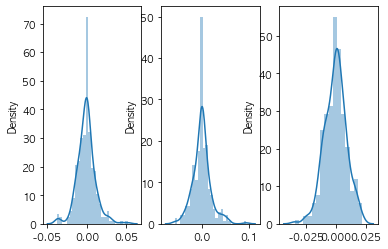

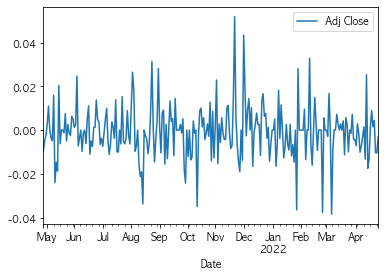

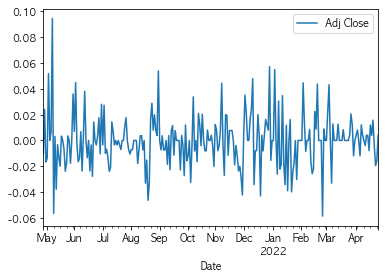

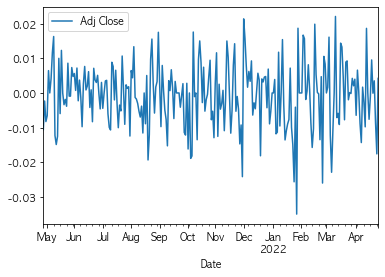

In [22]:
# 삼성전자, 노루홀딩스, 코스피 수익률 그래프 도출

for i,j in zip([large_cap_day, small_cap_day, kospi_day], range(3)):
    plt.subplot(1,3,j+1)
    sns.distplot(i)
plt.show()

for i in [large_cap_day, small_cap_day, kospi_day]:
    i.plot(kind='line')
    plt.show()

In [23]:
# 정규성 검정 (모수적 특성이 존재하는지 여부 판단)

# shapiro 검정 시행
from scipy.stats import shapiro

for i in [large_cap_day, small_cap_day, kospi_day]:
    stats, pval = shapiro(i)
    
    if pval < .05:
        print(f'p값이 {pval*100 : .3f}% 이므로 정규성을 충족한다는 귀무가설을 5% 유의수준으로 기각할 수 있습니다.')
    else:
        print(f'p값이 {pval*100 : .3f}% 이므로 정규성을 충족한다는 귀무가설을 5% 유의수준으로 기각할 수 없습니다.')


p값이  0.000% 이므로 정규성을 충족한다는 귀무가설을 5% 유의수준으로 기각할 수 있습니다.
p값이  0.000% 이므로 정규성을 충족한다는 귀무가설을 5% 유의수준으로 기각할 수 있습니다.
p값이  12.814% 이므로 정규성을 충족한다는 귀무가설을 5% 유의수준으로 기각할 수 없습니다.


## 참고) CAPM(자산가격결정모형), 회귀모형의 비교에 해당하는 이미지

![image](https://user-images.githubusercontent.com/87803612/165465325-61cd822e-aca5-44f2-8877-6ba0096372ee.png)

하지만, 코로나 시대 기준 금리가 제로금리에 이르렀고 추가로 분석의 편의를 위해 무위험수익률은 0%로 설정하여 상수항이 없는 회귀모형을 진행해본다.

쪼오끔 수정해야 함

## 단순회귀분석 시행

In [24]:
# 필요한 라이브러리
import statsmodels.api as sm

# target은 종속변수, feature는 독립변수와 같다.
target = large_cap_day
feature = kospi_day

# 상수항을 더해줘서 회귀식을 더 잘 적합할 수 있도록 만들어 준다.
feature_add = sm.add_constant(feature, has_constant='add')

# sm OLS 적합
model = sm.OLS(target, feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     309.7
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           4.38e-46
Time:                        13:21:26   Log-Likelihood:                 890.14
No. Observations:                 260   AIC:                            -1776.
Df Residuals:                     258   BIC:                            -1769.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -0.234      0.815      -0.001       0.001
Adj Close      0.9406      0.053     17.599      0.000       0.835       1.046
==============================================================================
Omnibus:                       37.458   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.430
Skew:                           0.601   Prob(JB):                     1.05e-24
Kurtosis:                       5.958   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

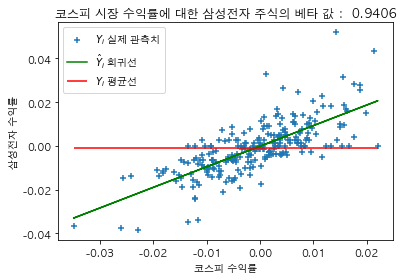

In [25]:
# 회귀선 도출
target_pred1 = fitted_model.predict()

plt.scatter(feature, target, marker='+', label='$Y_i$ 실제 관측치')
plt.plot(feature.values, target_pred1, color = 'g', label='$\hat{Y}_i$ 회귀선')
plt.hlines(target.mean(), feature.min(), feature.max(), color = 'r', label='$Y_i$ 평균선')
plt.legend()
plt.xlabel('코스피 수익률')
plt.ylabel('삼성전자 수익률')
plt.title(f'코스피 시장 수익률에 대한 삼성전자 주식의 베타 값 : {fitted_model.params[1] : .4f}')
plt.show()

In [26]:
# 필요한 라이브러리
import statsmodels.api as sm

# target은 종속변수, feature는 독립변수와 같다.
target2 = small_cap_day
feature = kospi_day

# 상수항을 더해줘서 회귀식을 더 잘 적합할 수 있도록 만들어 준다.
feature_add = sm.add_constant(feature, has_constant='add')

# sm OLS 적합
model = sm.OLS(target2, feature_add)
fitted_model2 = model.fit()

# summary 함수통해 결과출력
fitted_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     89.81
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.78e-18
Time:                        13:21:27   Log-Likelihood:                 694.37
No. Observations:                 260   AIC:                            -1385.
Df Residuals:                     258   BIC:                            -1378.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.398      0.691      -0.002       0.002
Adj Close      1.0755      0.113      9.477      0.000       0.852       1.299
==============================================================================
Omnibus:                       54.976   Durbin-Watson:                   2.220
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.561
Skew:                           0.808   Prob(JB):                     2.56e-47
Kurtosis:                       7.146   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

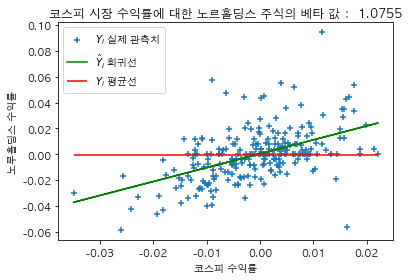

In [27]:
# 회귀선 도출
target_pred2 = fitted_model2.predict()

plt.scatter(feature, target2, marker='+', label='$Y_i$ 실제 관측치')
plt.plot(feature.values, target_pred2, color = 'g', label='$\hat{Y}_i$ 회귀선')
plt.hlines(target.mean(), feature.min(), feature.max(), color = 'r', label='$Y_i$ 평균선')
plt.legend()
plt.xlabel('코스피 수익률')
plt.ylabel('노루홀딩스 수익률')
plt.title(f'코스피 시장 수익률에 대한 노르홀딩스 주식의 베타 값 : {fitted_model2.params[1] : .4f}')
plt.show()

# 데이터 불러오기

In [28]:
# yfinance 데이터 불러오기 (3년치)
large_cap_price = yf.download('005930.KS', '2019-04-27', '2022-04-27', period='1d') # 삼성전자 (시총 388조)
small_cap_price = yf.download('000320.KS', '2019-04-27', '2022-04-27', period='1d') # 노루홀딩스 (시총 1600억)
kospi_price = yf.download('^KS11', '2019-04-27', '2022-04-27', period='1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## 데이터 전처리 (월간 수익률 전환)

In [29]:
def stock_return_month(data, column = 'Adj Close'):   
    data = data.reset_index()
    start = data['Date'].astype(str).iloc[0]
    end = data['Date'].astype(str).iloc[-1]

    # 날짜 처음과 끝에서 영업일 기준 freq 적용 후 데이터 프레임 형성
    b_day = pd.date_range(start, end, freq='B').to_frame().rename(columns={0:'Date'}).reset_index(drop=True)

    # 영업일, 기존 데이터 병합
    data = pd.merge(b_day, data, how='left')
    print(f'Nan값 개수 확인 : {data[column].isna().value_counts()[1]}')

    # 직전 값으로 NaN 값 채우기
    data = data.fillna(method='ffill')
    print(f'Nan값 개수 확인 : {data[column].isna().value_counts()}')

    # 월말 영업일 구하기
    month_end = pd.date_range(start, end, freq='BM')

    data = data[data['Date'].isin(month_end)].reset_index(drop=True)
    data = data.set_index(data['Date']).drop(columns='Date')

    # 전일대비 수익률 도출
    price = data[column].pct_change().dropna()
    price = pd.DataFrame(price)
    return price

large_cap_month = stock_return_month(large_cap_price)
small_cap_month = stock_return_month(small_cap_price)
kospi_month = stock_return_month(kospi_price)

Nan값 개수 확인 : 43
Nan값 개수 확인 : False    782
Name: Adj Close, dtype: int64
Nan값 개수 확인 : 43
Nan값 개수 확인 : False    782
Name: Adj Close, dtype: int64
Nan값 개수 확인 : 43
Nan값 개수 확인 : False    782
Name: Adj Close, dtype: int64


## 시각화 및 정규성 검정

/Users/jeong-giho/Desktop/financial_python/finance/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jeong-giho/Desktop/financial_python/finance/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jeong-giho/Desktop/financial_python/finance/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt you

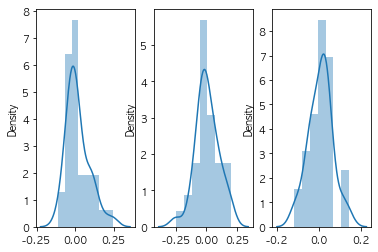

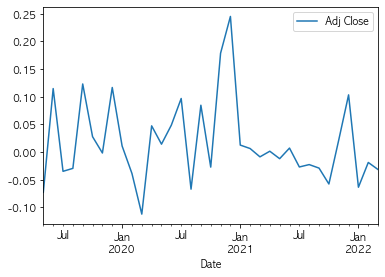

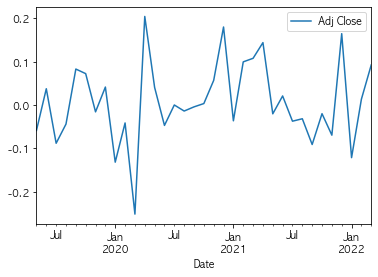

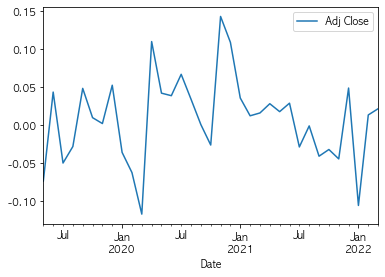

In [30]:
# 삼성전자, 노루홀딩스, 코스피 수익률 그래프 도출

for i,j in zip([large_cap_month, small_cap_month, kospi_month], range(3)):
    plt.subplot(1,3,j+1)
    sns.distplot(i)
plt.show()

for i in [large_cap_month, small_cap_month, kospi_month]:
    i.plot(kind='line')
    plt.show()

In [31]:
# 정규성 검정 (모수적 특성이 존재하는지 여부 판단)

# shapiro 검정 시행
from scipy.stats import shapiro

for i in [large_cap_month, small_cap_month, kospi_month]:
    stats, pval = shapiro(i)
    
    if pval < .05:
        print(f'p값이 {pval*100 : .3f}% 이므로 정규성을 충족한다는 귀무가설을 5% 유의수준으로 기각할 수 있습니다.')
    else:
        print(f'p값이 {pval*100 : .3f}% 이므로 정규성을 충족한다는 귀무가설을 5% 유의수준으로 기각할 수 없습니다.')


p값이  1.375% 이므로 정규성을 충족한다는 귀무가설을 5% 유의수준으로 기각할 수 있습니다.
p값이  65.830% 이므로 정규성을 충족한다는 귀무가설을 5% 유의수준으로 기각할 수 없습니다.
p값이  70.543% 이므로 정규성을 충족한다는 귀무가설을 5% 유의수준으로 기각할 수 없습니다.


## 단순회귀분석 시행

In [32]:
# 필요한 라이브러리
import statsmodels.api as sm

# target은 종속변수, feature는 독립변수와 같다.
target = large_cap_month
feature = kospi_month

# 상수항을 더해줘서 회귀식을 더 잘 적합할 수 있도록 만들어 준다.
feature_add = sm.add_constant(feature, has_constant='add')

# sm OLS 적합
model = sm.OLS(target, feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     52.55
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           2.58e-08
Time:                        13:21:32   Log-Likelihood:                 57.836
No. Observations:                  35   AIC:                            -111.7
Df Residuals:                      33   BIC:                            -108.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0087      0.008      1.069      0.293      -0.008       0.025
Adj Close      1.0451      0.144      7.249      0.000       0.752       1.338
==============================================================================
Omnibus:                        1.184   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.553   Jarque-Bera (JB):                0.436
Skew:                           0.223   Prob(JB):                        0.804
Kurtosis:                       3.318   Cond. No.                         17.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

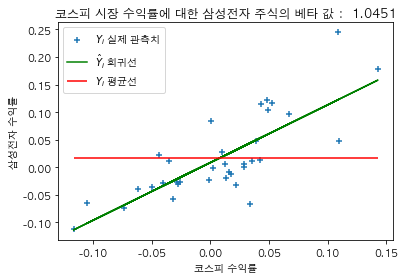

In [33]:
# 회귀선 도출
target_pred1 = fitted_model.predict()

plt.scatter(feature, target, marker='+', label='$Y_i$ 실제 관측치')
plt.plot(feature.values, target_pred1, color = 'g', label='$\hat{Y}_i$ 회귀선')
plt.hlines(target.mean(), feature.min(), feature.max(), color = 'r', label='$Y_i$ 평균선')
plt.legend()
plt.xlabel('코스피 수익률')
plt.ylabel('삼성전자 수익률')
plt.title(f'코스피 시장 수익률에 대한 삼성전자 주식의 베타 값 : {fitted_model.params[1] : .4f}')
plt.show()

In [34]:
# 필요한 라이브러리
import statsmodels.api as sm

# target은 종속변수, feature는 독립변수와 같다.
target2 = small_cap_month
feature = kospi_month

# 상수항을 더해줘서 회귀식을 더 잘 적합할 수 있도록 만들어 준다.
feature_add = sm.add_constant(feature, has_constant='add')

# sm OLS 적합
model = sm.OLS(target2, feature_add)
fitted_model2 = model.fit()

# summary 함수통해 결과출력
fitted_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     48.48
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           5.85e-08
Time:                        13:21:33   Log-Likelihood:                 49.312
No. Observations:                  35   AIC:                            -94.62
Df Residuals:                      33   BIC:                            -91.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0035      0.010     -0.338      0.738      -0.025       0.018
Adj Close      1.2807      0.184      6.963      0.000       0.906       1.655
==============================================================================
Omnibus:                        0.471   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.790   Jarque-Bera (JB):                0.589
Skew:                          -0.055   Prob(JB):                        0.745
Kurtosis:                       2.374   Cond. No.                         17.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

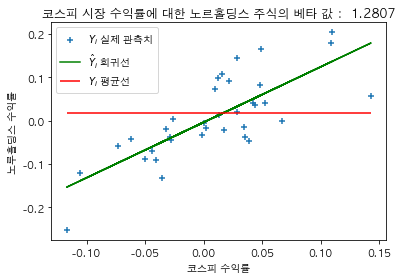

In [35]:
# 회귀선 도출
target_pred2 = fitted_model2.predict()

plt.scatter(feature, target2, marker='+', label='$Y_i$ 실제 관측치')
plt.plot(feature.values, target_pred2, color = 'g', label='$\hat{Y}_i$ 회귀선')
plt.hlines(target.mean(), feature.min(), feature.max(), color = 'r', label='$Y_i$ 평균선')
plt.legend()
plt.xlabel('코스피 수익률')
plt.ylabel('노루홀딩스 수익률')
plt.title(f'코스피 시장 수익률에 대한 노르홀딩스 주식의 베타 값 : {fitted_model2.params[1] : .4f}')
plt.show()